# 准备工具

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# libraries
from operator import itemgetter
from IPython.display import display_html
from math import sqrt

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import folium
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 数据探索

## Constructing the networks

In [3]:
# read in london.graph.xml
G = nx.read_graphml("london.graph")

In [4]:
type(G)

networkx.classes.graph.Graph

In [5]:
# list all operations of the G object
print(len(dir(G)))
for i in np.random.randint(0, len(dir(G)), 10):
    print(dir(G)[i])

76
node_dict_factory
__reduce_ex__
__ge__
number_of_edges
update
adjlist_outer_dict_factory
edge_subgraph
subgraph
__subclasshook__
__reduce__


In [6]:
print(G.number_of_nodes())
print(G.number_of_edges())

401
467


In [7]:
# compute all possible nodes
print(G.number_of_edges() / (G.number_of_nodes() * (G.number_of_nodes() - 1)))

0.0029114713216957604


In [8]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [9]:
# since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [10]:
# To check node attributes again:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

In [11]:
# To check edges attributes:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

In [12]:
# To check edges type:
type(list(G.edges(data = True)))

list

In [13]:
# add station_name attribute to node
node_name = {}
for i in list(G.nodes(data = True)):
    node_name[i[0]] = i[0]
nx.set_node_attributes(G,node_name,'station_name')

In [14]:
# we can also add the stations name to the edge attributes from the nodes attributes:

nod_name1={(e1,e2):(G.nodes[e1]['station_name']) for e1, e2 in G.edges()}
nod_name2={(e1,e2):(G.nodes[e2]['station_name']) for e1, e2 in G.edges()}

nx.set_edge_attributes(G,nod_name1,'station_1')
nx.set_edge_attributes(G,nod_name2,'station_2')

In [15]:
# To check edges attributes again:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483,
  'line_name': 'Jubilee',
  'flows': 12356,
  'station_1': 'Wembley Park',
  'station_2': 'Kingsbury'})

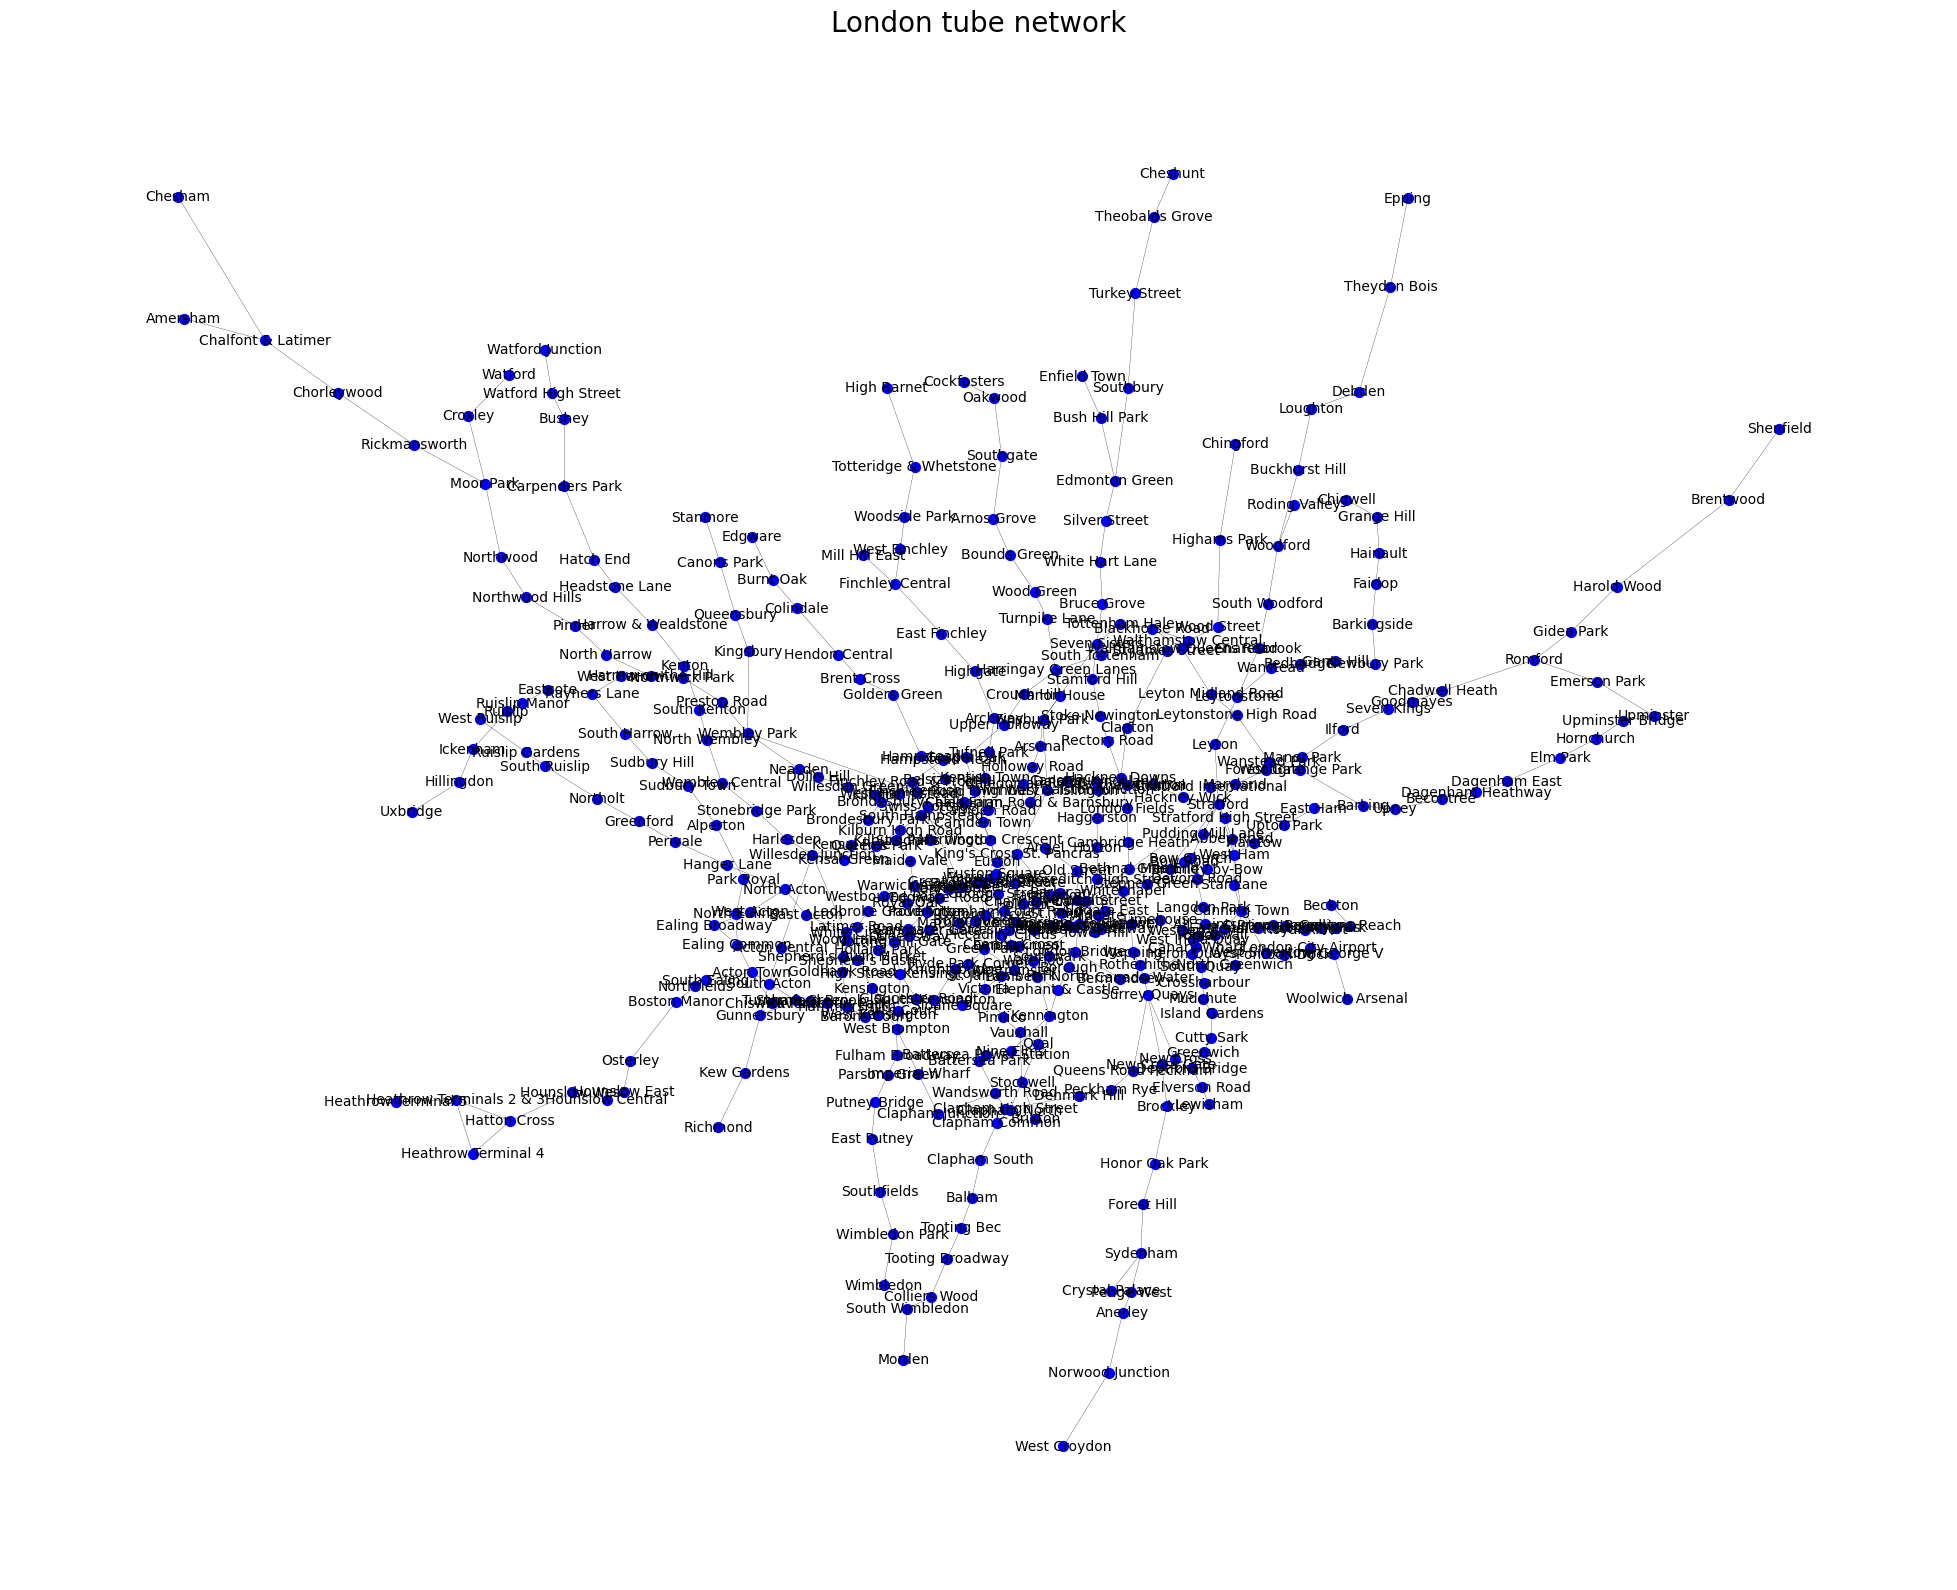

In [16]:
# Plot the tube network to check
fig, ax = plt.subplots(figsize=(25,20))

node_labels = nx.get_node_attributes(G, 'station_name')

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=20)
plt.axis("off")
plt.show()

In [17]:
# check edge list
df = nx.to_pandas_edgelist(G)
df.head(10)

,source,target,station_2,line_name,length,flows,station_1
0,Wembley Park,Kingsbury,Kingsbury,Jubilee,2916.771558,12356,Wembley Park
1,Wembley Park,Neasden,Neasden,Jubilee,2353.165938,6744,Wembley Park
2,Wembley Park,Preston Road,Preston Road,Metropolitan,1419.735166,36601,Wembley Park
3,Wembley Park,Finchley Road,Finchley Road,Metropolitan,7266.373927,55216,Wembley Park
4,Kingsbury,Queensbury,Queensbury,Jubilee,1245.995234,9419,Kingsbury
5,Queensbury,Canons Park,Canons Park,Jubilee,1693.307343,6385,Queensbury
6,Canons Park,Stanmore,Stanmore,Jubilee,1419.669476,3624,Canons Park
7,Stratford,West Ham,West Ham,Jubilee,1673.509515,91801,Stratford
8,Stratford,Mile End,Mile End,Central,2805.001392,12010,Stratford
9,Stratford,Leyton,Leyton,Central,2131.342926,56082,Stratford


# Part 1: London’s Underground Resilience

## I.Topological Network

### I.1 Centrality Measures

#### Closeness Centrality
Definition:Closeness Centrality is a score that indicates how close a node is to all other nodes in the network, based on the shortest paths.

Why choose: Identifies stations that offer the shortest average journey time to all other stations.
\begin{equation} C_{i}= \frac{1}{l_{i}} = \frac{n}{\sum_{j} d_{ij}}\end{equation}

#### Betweeness Centrality
Definition:Betweeness Centrality measures the extent to which a node lies on the shortest path between other nodes in the network.

Why choose: Identifies stations that , if closed, would cause the greatest increase in journey times across the network
\begin{equation} C_{b}(v) = \sum_{s,t \neq v} \frac{\sigma_(s)(t)(v)}{\sigma_{st}} \end{equation}    

#### Eigenvector Centrality
Definition: Eigenvector Centrality takes into account not only the number of direct connections of a node, but also the quality of these connected nodes (their own connections).

Why choose: In a transport network, using Degree Centrality it is possible to find out which stations have a high number of connections, but this does not necessarily mean that the station is very important, as it may be a connecting station used to switch routes. Eigenvector Centrality, on the other hand, measures not only the number of connections at a site, but also the number of connections at the sites it connects to. Sites with high values from Eigenvector Centrality are likely to be more important points in the network.
\begin{equation} x_v = \frac{1}{\lambda}\sum_{t\in M(v)} x_t\end{equation}n}

#### Topological Closeness Centrality

In [18]:
#topological closeness centrality
clos_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

df_clos_t = df.sort_values(["closeness_t"], ascending=False)
df_clos_t[0:10]

,station_name,closeness_t
Green Park,Green Park,0.114778
Bank and Monument,Bank and Monument,0.113572
King's Cross St. Pancras,King's Cross St. Pancras,0.113443
Westminster,Westminster,0.112549
Waterloo,Waterloo,0.112265
Oxford Circus,Oxford Circus,0.111204
Bond Street,Bond Street,0.110988
Farringdon,Farringdon,0.110742
Angel,Angel,0.110742
Moorgate,Moorgate,0.110314


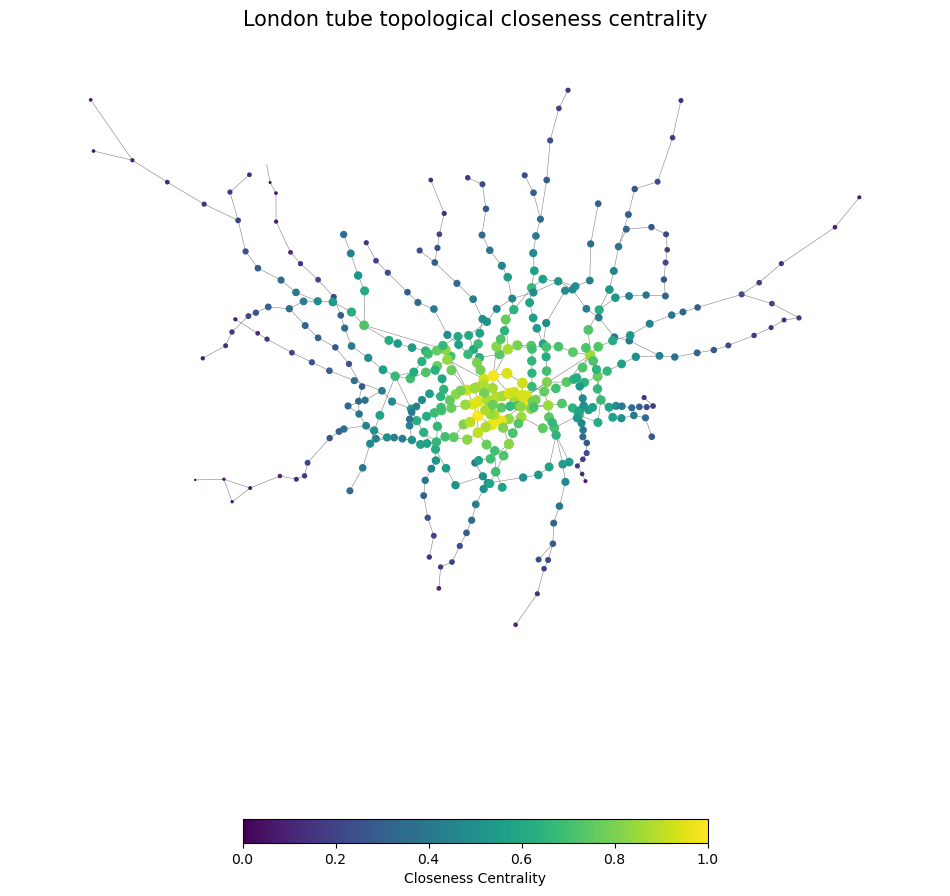

In [19]:
# Lets set color and width of nodes according to the closeness values
clos_t_val=[(i[1]['closeness_t']) for i in G.nodes(data=True)]

closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G.nodes(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological closeness centrality",fontsize=15)
plt.show()

#### Topological Betweeness Centrality

In [20]:
# topological betweenness centrality:

bet_t=nx.betweenness_centrality(G, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_t,'betweenness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

df_bet_t = df.sort_values(["betweenness_t"], ascending=False)
df_bet_t[0:10]

,station_name,betweenness_t
Stratford,Stratford,23768.093434
Bank and Monument,Bank and Monument,23181.058947
Liverpool Street,Liverpool Street,21610.387049
King's Cross St. Pancras,King's Cross St. Pancras,20373.521465
Waterloo,Waterloo,19464.882323
Green Park,Green Park,17223.622114
Euston,Euston,16624.275469
Westminster,Westminster,16226.155916
Baker Street,Baker Street,15287.107612
Finchley Road,Finchley Road,13173.758009


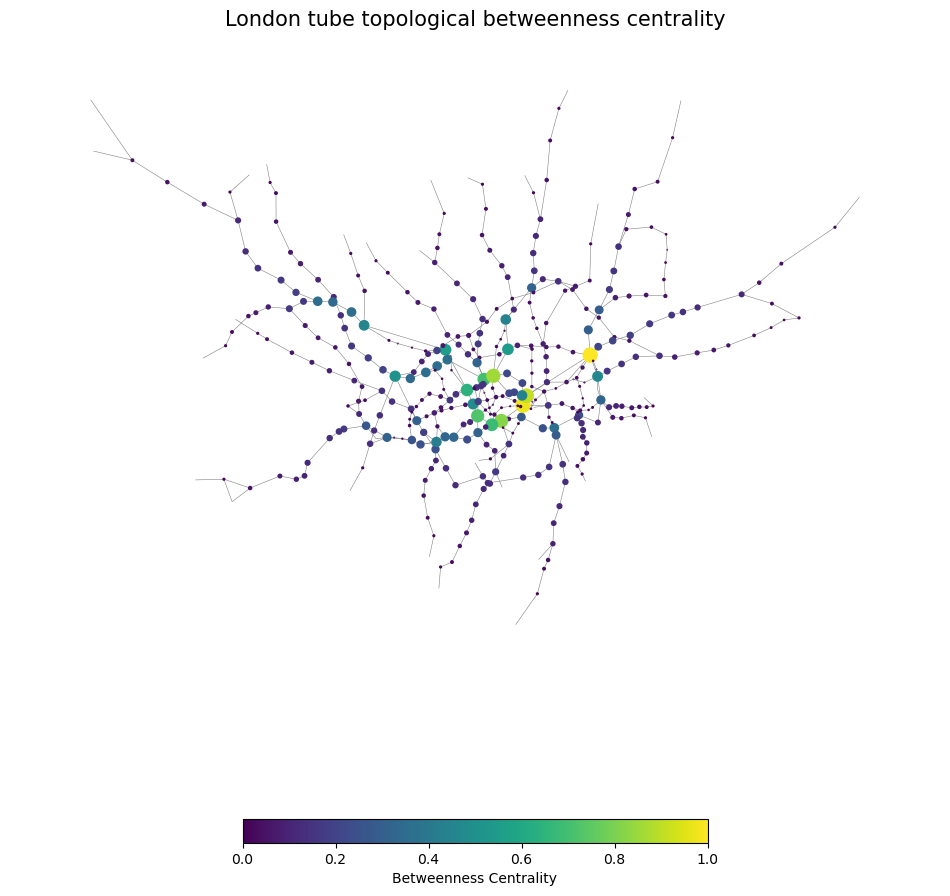

In [21]:
# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.show()

#### Eigenvector Centrality

In [22]:
#eigenvector centrality
eig_centrality = nx.eigenvector_centrality(G, max_iter=1000)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G, eig_centrality, 'eigenvector_centrality')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['eigenvector_centrality'] = pd.Series(nx.get_node_attributes(G, 'eigenvector_centrality'))

df_eig = df.sort_values(["eigenvector_centrality"], ascending=False)
df_eig.head(10)

,station_name,eigenvector_centrality
Bank and Monument,Bank and Monument,0.383427
Liverpool Street,Liverpool Street,0.328824
Stratford,Stratford,0.269179
Waterloo,Waterloo,0.249731
Moorgate,Moorgate,0.215137
Green Park,Green Park,0.197630
Oxford Circus,Oxford Circus,0.184094
Tower Hill,Tower Hill,0.171676
Westminster,Westminster,0.168610
Shadwell,Shadwell,0.159090


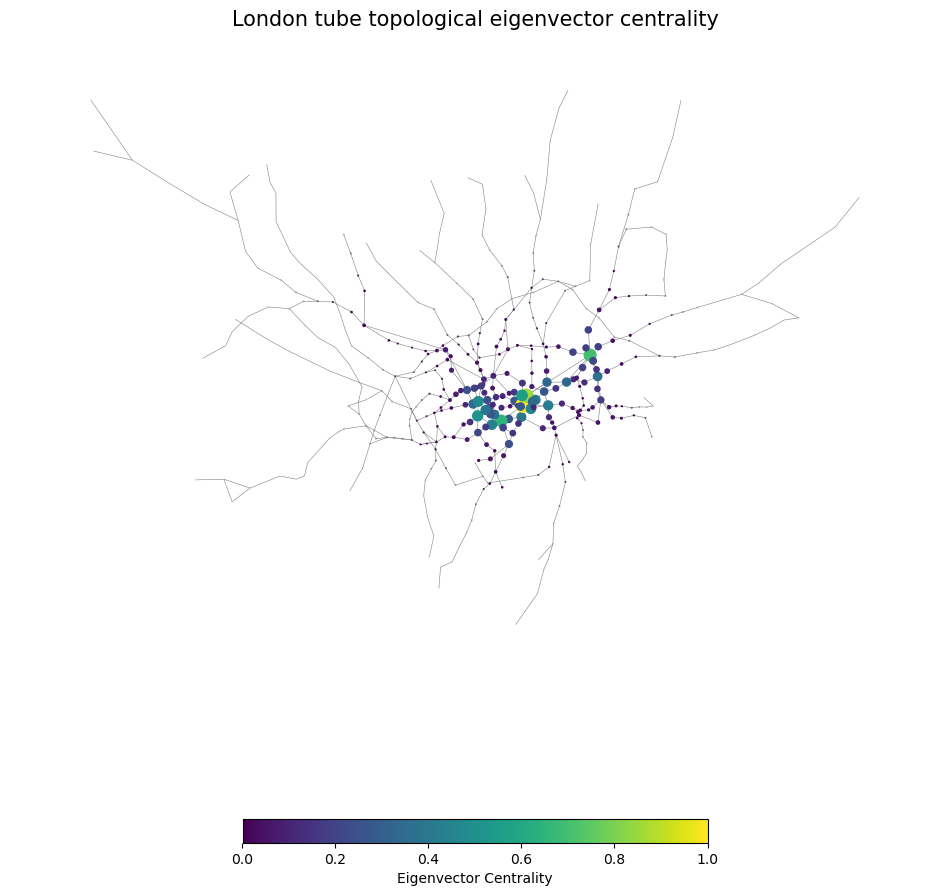

In [23]:
# Lets set colour and size of nodes according to eigenvector values
eigenvector_centrality_values = [(i[1]['eigenvector_centrality']) for i in G.nodes(data=True)]

eig_centrality_color = [(i[1]['eigenvector_centrality']/max(eigenvector_centrality_values)) for i in G.nodes(data=True)]
eig_centrality_size = [(i[1]['eigenvector_centrality']/max(eigenvector_centrality_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.4)

nod = nx.draw_networkx_nodes(G, pos=pos, node_color=eig_centrality_color, node_size=eig_centrality_size)

plt.colorbar(nod, label="Eigenvector Centrality", orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological eigenvector centrality", fontsize=15)
plt.show()

### I.2Impact measures:

#### **Largest Component (LC) Size**
Definition：
The number of nodes in the largest connected component of the network. This size not only reflects the connectivity in the network

Why Choose:
When a node is deleted, the maximum connected subgraph in the network will change. In the traffic network the largest one connectivity subgraph will ensure the connectivity of the whole network and the stability of the information transmission.

#### **Global Efficiency**
Definition：
A metric used in network theory to measure the overall communication efficiency of a network

Why Choose:
The connectivity of the network is affected when a node is removed, which leads to a reduction in global efficiency. Global efficiency can be used as a key metric to determine how the network is connected to improve the overall efficiency of information transfer.
\begin{equation} E_{\text{glob}}(G) = \frac{1}{N(N-1)} \sum_{i \neq j \in V} \frac{1}{d(i,j)}\end{equation}

#### Define Function

In [24]:
#Creating largest_component_size function
def largest_component_size(G):
    """Calculate the size of the largest connected component in the graph."""
    if nx.is_empty(G):  # 检查图是否为空
        return 0
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc)

In [25]:
#The largest_component_size of the current G
print("Largest Component Size:", largest_component_size(G))

Largest Component Size: 401


In [26]:
#Creating global_efficiency function
def global_efficiency(G):
    """Calculate the global efficiency of the graph."""
    N = len(G)
    if N < 2:  # 如果图中少于两个节点，效率为0
        return 0

    eff = 0.0
    for u in G.nodes():
        length = nx.single_source_shortest_path_length(G, u)
        # 加入对非连通路径的处理
        eff += sum(1.0 / d for d in length.values() if d > 0)  # 只计算存在路径的节点对

    # 确保除数不为零
    if N * (N - 1) == 0:
        return 0

    return eff / (N * (N - 1))  # 归一化全球效率

In [27]:
#The global_efficiency of the current G
print("Global Efficiency:", global_efficiency(G))

Global Efficiency: 0.10125619359712325


### I.3Node removal

#### Creat Copies of G 

In [28]:
# creating non-sequential graphs
G_clos_ns = G.copy() #Topological Closeness Centrality
G_bet_ns = G.copy() #Topological Betweeness Centrality
G_eig_ns = G.copy() #Eigenvector Centrality

In [29]:
print("Number of nodes in G_clos_ns after copy:", G_clos_ns.number_of_nodes())
print("Number of edges in G_clos_ns after copy:", G_clos_ns.number_of_edges())

print("Number of nodes in G_bet_ns after copy:", G_bet_ns.number_of_nodes())
print("Number of edges in G_bet_ns after copy:", G_bet_ns.number_of_edges())

print("Number of nodes in G_eig_ns after copy:", G_eig_ns.number_of_nodes())
print("Number of edges in G_eig_ns after copy:", G_eig_ns.number_of_edges())

Number of nodes in G_clos_ns after copy: 401
Number of edges in G_clos_ns after copy: 467
Number of nodes in G_bet_ns after copy: 401
Number of edges in G_bet_ns after copy: 467
Number of nodes in G_eig_ns after copy: 401
Number of edges in G_eig_ns after copy: 467


In [30]:
# creating sequential graphs
G_clos_s = G.copy() #Topological Closeness Centrality
G_bet_s = G.copy() #Topological Betweeness Centrality
G_eig_s = G.copy() #Eigenvector Centrality

In [31]:
print("Number of nodes in G_clos_s after copy:", G_clos_s.number_of_nodes())
print("Number of edges in G_clos_s after copy:", G_clos_s.number_of_edges())

print("Number of nodes in G_bet_s after copy:", G_bet_s.number_of_nodes())
print("Number of edges in G_bet_s after copy:", G_bet_s.number_of_edges())

print("Number of nodes in G_eig_s after copy:", G_eig_s.number_of_nodes())
print("Number of edges in G_eig_s after copy:", G_eig_s.number_of_edges())

Number of nodes in G_clos_s after copy: 401
Number of edges in G_clos_s after copy: 467
Number of nodes in G_bet_s after copy: 401
Number of edges in G_bet_s after copy: 467
Number of nodes in G_eig_s after copy: 401
Number of edges in G_eig_s after copy: 467


#### No-sequential

In [32]:
#Topological Closeness Centrality

# 初始化列表
removed_nodes = []
component_sizes = []
efficiencies = []

# 限制删除节点的数量为10
for node in df_clos_t['station_name'][:10]:  # 限制为前10个节点
    if node in G_clos_ns.nodes:  # 确保节点存在于图中
        G_clos_ns.remove_node(node)  # 先删除节点
        # 计算指标并存储到各自的列表中
        removed_nodes.append(node)
        component_sizes.append(largest_component_size(G_clos_ns))
        efficiencies.append(global_efficiency(G_clos_ns))

# 创建一个包含所有信息的DataFrame
results_clos_ns = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_clos_ns

,Removed Node,Largest Component Size,Global Efficiency
0,Green Park,400,0.099190
1,Bank and Monument,399,0.094872
2,King's Cross St. Pancras,398,0.087934
3,Westminster,397,0.087372
4,Waterloo,396,0.084859
5,Oxford Circus,395,0.082781
6,Bond Street,394,0.082581
7,Farringdon,393,0.082600
8,Angel,392,0.082622
9,Moorgate,389,0.081670


In [33]:
#Topological Betweeness Centrality

# 初始化列表
removed_nodes = []
component_sizes = []
efficiencies = []

# 限制删除节点的数量为10
for node in df_bet_t['station_name'][:10]:  # 限制为前10个节点
    if node in G_bet_ns.nodes:  # 确保节点存在于图中
        G_bet_ns.remove_node(node)  # 先删除节点
        # 计算指标并存储到各自的列表中
        removed_nodes.append(node)
        component_sizes.append(largest_component_size(G_bet_ns))
        efficiencies.append(global_efficiency(G_bet_ns))

# 创建一个包含所有信息的DataFrame
results_bet_ns = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_bet_ns

,Removed Node,Largest Component Size,Global Efficiency
0,Stratford,379,0.088917
1,Bank and Monument,378,0.085862
2,Liverpool Street,377,0.084963
3,King's Cross St. Pancras,371,0.078498
4,Waterloo,370,0.075942
5,Green Park,369,0.074152
6,Euston,346,0.068206
7,Westminster,345,0.067660
8,Baker Street,342,0.064700
9,Finchley Road,339,0.063139


In [34]:
#Eigenvector Centrality

# 初始化列表
removed_nodes = []
component_sizes = []
efficiencies = []

# 限制删除节点的数量为10
for node in df_eig['station_name'][:10]:  # 限制为前10个节点
    if node in G_eig_ns.nodes:  # 确保节点存在于图中
        G_eig_ns.remove_node(node)  # 先删除节点
        # 计算指标并存储到各自的列表中
        removed_nodes.append(node)
        component_sizes.append(largest_component_size(G_eig_ns))
        efficiencies.append(global_efficiency(G_eig_ns))

# 创建一个包含所有信息的DataFrame
results_eig_ns = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_eig_ns

,Removed Node,Largest Component Size,Global Efficiency
0,Bank and Monument,400,0.096735
1,Liverpool Street,399,0.094668
2,Stratford,377,0.084963
3,Waterloo,376,0.082797
4,Moorgate,375,0.082749
5,Green Park,374,0.080953
6,Oxford Circus,373,0.080104
7,Tower Hill,371,0.079741
8,Westminster,370,0.079100
9,Shadwell,368,0.077579


#### Sequential

In [35]:
#Topological Closeness Centrality

# 初始化列表
removed_nodes = []
component_sizes = []
efficiencies = []
clos_centrality = []  # 存储被移除节点的中心性

# 重复删除节点并重新计算中心性，直到删除了10个节点
for _ in range(10):
    if G_clos_s.number_of_nodes() == 0:
        break  # 如果图已经空了，跳出循环
    
    # 重新计算中心性
    centrality = nx.closeness_centrality(G_clos_s)
    
    # 找到中心性最高的节点
    highest_centrality_node = max(centrality, key=centrality.get)
    max_centrality_value = centrality[highest_centrality_node]  # 记录最高中心性值
    
    # 删除中心性最高的节点
    G_clos_s.remove_node(highest_centrality_node)
    
    # 计算指标
    largest_component_size_value = largest_component_size(G_clos_s)
    global_efficiency_value = global_efficiency(G_clos_s)

    # 记录结果
    removed_nodes.append(highest_centrality_node)
    component_sizes.append(largest_component_size_value)
    efficiencies.append(global_efficiency_value)
    clos_centrality.append(max_centrality_value)  # 记录被删除节点的中心性值

# 将记录转换为DataFrame以便进一步分析
results_clos_s = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Degree Centrality': clos_centrality,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_clos_s

,Removed Node,Degree Centrality,Largest Component Size,Global Efficiency
0,Green Park,0.114778,400,0.099190
1,King's Cross St. Pancras,0.112363,399,0.094435
2,Waterloo,0.104654,398,0.091816
3,Bank and Monument,0.097423,397,0.085426
4,West Hampstead,0.081734,396,0.080544
5,Canada Water,0.075976,226,0.058101
6,Stratford,0.063732,226,0.051884
7,Earl's Court,0.063645,225,0.050350
8,Shepherd's Bush,0.060434,195,0.044395
9,Oxford Circus,0.050501,194,0.042958


In [36]:
#Topological Betweeness Centrality

# 初始化列表
removed_nodes = []
component_sizes = []
efficiencies = []
bet_centrality = []  # 存储被移除节点的中心性

# 重复删除节点并重新计算中心性，直到删除了10个节点
for _ in range(10):
    if G_bet_s.number_of_nodes() == 0:
        break  # 如果图已经空了，跳出循环
    
    # 重新计算中心性
    centrality = nx.betweenness_centrality(G_bet_s)
    
    # 找到中心性最高的节点
    highest_centrality_node = max(centrality, key=centrality.get)
    max_centrality_value = centrality[highest_centrality_node]  # 记录最高中心性值
    
    # 删除中心性最高的节点
    G_bet_s.remove_node(highest_centrality_node)
    
    # 计算指标
    largest_component_size_value = largest_component_size(G_bet_s)
    global_efficiency_value = global_efficiency(G_bet_s)

    # 记录结果
    removed_nodes.append(highest_centrality_node)
    component_sizes.append(largest_component_size_value)
    efficiencies.append(global_efficiency_value)
    bet_centrality.append(max_centrality_value)  # 记录被删除节点的中心性值

# 将记录转换为DataFrame以便进一步分析
results_bet_s = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Degree Centrality': bet_centrality,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_bet_s

,Removed Node,Degree Centrality,Largest Component Size,Global Efficiency
0,Stratford,0.297846,379,0.088917
1,King's Cross St. Pancras,0.247262,378,0.084603
2,Waterloo,0.254180,377,0.081829
3,Bank and Monument,0.214651,376,0.077678
4,Canada Water,0.244903,375,0.072832
5,West Hampstead,0.456831,227,0.053210
6,Earl's Court,0.096182,226,0.051656
7,Shepherd's Bush,0.128852,196,0.045844
8,Euston,0.087075,173,0.041631
9,Baker Street,0.098437,170,0.038164


In [37]:
#Eigenvector Centrality

# 初始化列表
removed_nodes = []
component_sizes = []
efficiencies = []
eig_centrality = []  # 存储被移除节点的中心性

# 重复删除节点并重新计算中心性，直到删除了10个节点
for _ in range(10):
    if G_eig_s.number_of_nodes() == 0:
        break  # 如果图已经空了，跳出循环
    
    # 重新计算中心性
    centrality = nx.eigenvector_centrality(G_eig_s, max_iter=1000)
    
    # 找到中心性最高的节点
    highest_centrality_node = max(centrality, key=centrality.get)
    max_centrality_value = centrality[highest_centrality_node]  # 记录最高中心性值
    
    # 删除中心性最高的节点
    G_eig_s.remove_node(highest_centrality_node)
    
    # 计算指标
    largest_component_size_value = largest_component_size(G_eig_s)
    global_efficiency_value = global_efficiency(G_eig_s)

    # 记录结果
    removed_nodes.append(highest_centrality_node)
    component_sizes.append(largest_component_size_value)
    efficiencies.append(global_efficiency_value)
    eig_centrality.append(max_centrality_value)  # 记录被删除节点的中心性值

# 将记录转换为DataFrame以便进一步分析
results_eig_s = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Degree Centrality': eig_centrality,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_eig_s

,Removed Node,Degree Centrality,Largest Component Size,Global Efficiency
0,Bank and Monument,0.383427,400,0.096735
1,Oxford Circus,0.416543,399,0.095722
2,Stratford,0.530685,377,0.084813
3,Earl's Court,0.411513,376,0.083369
4,Westminster,0.316724,375,0.082412
5,Baker Street,0.427186,373,0.078219
6,King's Cross St. Pancras,0.516549,370,0.072074
7,Canning Town,0.530726,356,0.066899
8,Turnham Green,0.538152,355,0.065458
9,Leicester Square,0.420549,354,0.064080


#### Plot and Analysis

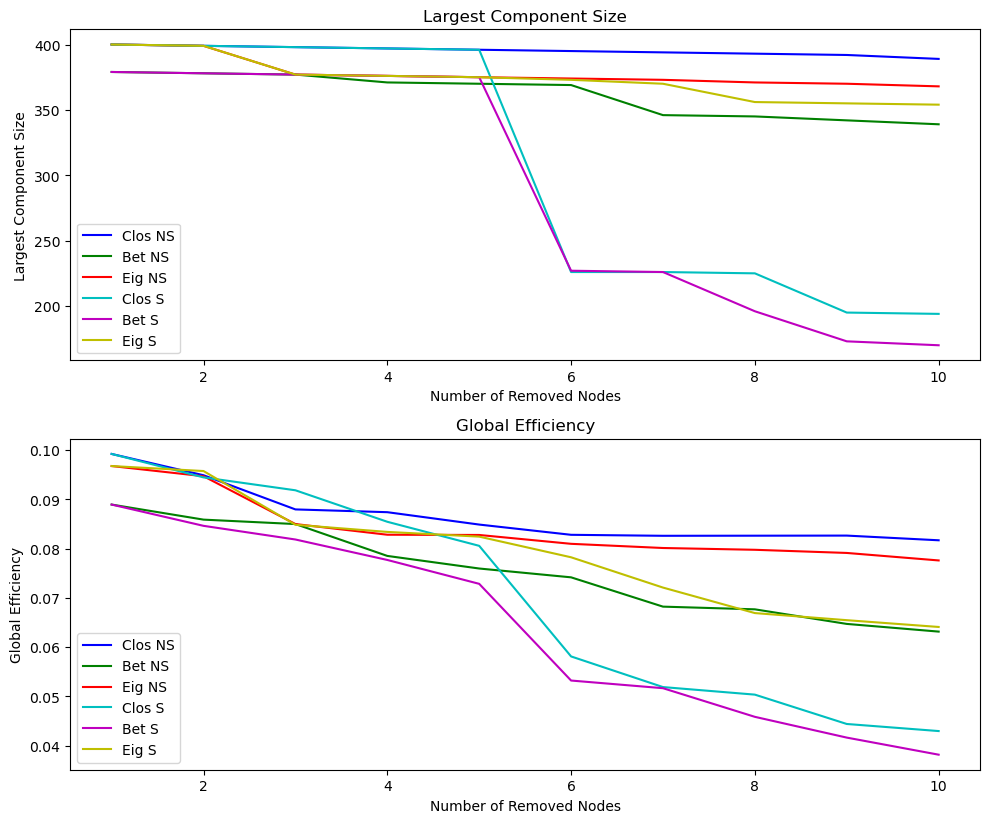

In [38]:
# 假设results_clos_ns等都已经是pandas DataFrame，并已经正确加载
dataframes = {
    'Clos NS': results_clos_ns,
    'Bet NS': results_bet_ns,
    'Eig NS': results_eig_ns,
    'Clos S': results_clos_s,
    'Bet S': results_bet_s,
    'Eig S': results_eig_s
}

# 设置图表大小
plt.figure(figsize=(10, 12))

# 为每个指标创建一个子图
metrics = ['Largest Component Size', 'Global Efficiency']
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # 颜色列表
plot_titles = ['Largest Component Size', 'Global Efficiency']

for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i + 1)  # 3行1列的子图布局
    for j, (label, df) in enumerate(dataframes.items()):
        x = range(1, 11)  # 假设每个数据集有10个节点被移除
        plt.plot(x, df[metric], label=f"{label}", color=colors[j], linestyle='-')

    plt.title(plot_titles[i])  # 为每个子图设置标题
    plt.xlabel('Number of Removed Nodes')
    plt.ylabel(metric)
    plt.legend()

# 调整子图间距
plt.tight_layout()

# 显示图表
plt.show()

## II.Flows: Weighted Network

### Inverse weights

In [39]:
G_weighted =  G.copy() # Weighted Graph

print("Number of nodes in G_weighted after copy:", G_weighted.number_of_nodes())
print("Number of edges in G_weighted after copy:", G_weighted.number_of_edges())

Number of nodes in G_weighted after copy: 401
Number of edges in G_weighted after copy: 467


In [40]:
# Inverse weights:

# Create a list to hold the edges where flow is 0
zero_flow_edges = [(e1, e2) for e1, e2, flows in G_weighted.edges(data='flows') if flows == 0]

# Set a very small positive number for edges where flow is 0 to avoid division by zero later
for e1, e2 in zero_flow_edges:
    G_weighted[e1][e2]['flows'] = 0.00000001

# Computes inv_flows for all edges, now that there are no zero flows
inv_flows = {(e1, e2): round(1./(flows + 0.000000000001), 7)
             for e1, e2, flows in G_weighted.edges(data='flows')}

# Set the calculated inverse flows as an edge attribute
nx.set_edge_attributes(G_weighted, inv_flows, 'inv_flows')

# Print the first 10 edges with their attributes to verify the changes
print(list(G_weighted.edges(data=True))[0:10])

[('Wembley Park', 'Kingsbury', {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356, 'station_1': 'Wembley Park', 'station_2': 'Kingsbury', 'inv_flows': 8.09e-05}), ('Wembley Park', 'Neasden', {'length': 2353.1659381957816, 'line_name': 'Jubilee', 'flows': 6744, 'station_1': 'Wembley Park', 'station_2': 'Neasden', 'inv_flows': 0.0001483}), ('Wembley Park', 'Preston Road', {'length': 1419.7351657633037, 'line_name': 'Metropolitan', 'flows': 36601, 'station_1': 'Wembley Park', 'station_2': 'Preston Road', 'inv_flows': 2.73e-05}), ('Wembley Park', 'Finchley Road', {'length': 7266.37392749648, 'line_name': 'Metropolitan', 'flows': 55216, 'station_1': 'Wembley Park', 'station_2': 'Finchley Road', 'inv_flows': 1.81e-05}), ('Kingsbury', 'Queensbury', {'length': 1245.9952343630068, 'line_name': 'Jubilee', 'flows': 9419, 'station_1': 'Kingsbury', 'station_2': 'Queensbury', 'inv_flows': 0.0001062}), ('Queensbury', 'Canons Park', {'length': 1693.307343195774, 'line_name': 'Jubile

In [41]:
zero_flow_edges

[('Wandsworth Road', 'Battersea Park'),
 ('Kennington', 'Nine Elms'),
 ('Battersea Power Station', 'Nine Elms')]

In [42]:
# check edge list
df = nx.to_pandas_edgelist(G_weighted)
df.head(10)

,source,target,inv_flows,station_2,line_name,length,flows,station_1
0,Wembley Park,Kingsbury,0.000081,Kingsbury,Jubilee,2916.771558,12356.0,Wembley Park
1,Wembley Park,Neasden,0.000148,Neasden,Jubilee,2353.165938,6744.0,Wembley Park
2,Wembley Park,Preston Road,0.000027,Preston Road,Metropolitan,1419.735166,36601.0,Wembley Park
3,Wembley Park,Finchley Road,0.000018,Finchley Road,Metropolitan,7266.373927,55216.0,Wembley Park
4,Kingsbury,Queensbury,0.000106,Queensbury,Jubilee,1245.995234,9419.0,Kingsbury
5,Queensbury,Canons Park,0.000157,Canons Park,Jubilee,1693.307343,6385.0,Queensbury
6,Canons Park,Stanmore,0.000276,Stanmore,Jubilee,1419.669476,3624.0,Canons Park
7,Stratford,West Ham,0.000011,West Ham,Jubilee,1673.509515,91801.0,Stratford
8,Stratford,Mile End,0.000083,Mile End,Central,2805.001392,12010.0,Stratford
9,Stratford,Leyton,0.000018,Leyton,Central,2131.342926,56082.0,Stratford


### II.1 Weighted Betweeness Centrality 

#### Weigtht = 1/flow

In [43]:
# weighted betweenness centrality，weight is inv_flows
bet_w=nx.betweenness_centrality(G_weighted, weight='inv_flows')
# We can add these values to the nodes attributes:
nx.set_node_attributes(G_weighted,bet_w,'betweenness_w')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G_weighted.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G_weighted, 'station_name'))
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G_weighted, 'betweenness_w'))

df_bet_w = df.sort_values(["betweenness_w"], ascending=False)
df_bet_w[0:10]

,station_name,betweenness_w
Green Park,Green Park,0.572556
Bank and Monument,Bank and Monument,0.505288
Waterloo,Waterloo,0.416429
Westminster,Westminster,0.381366
Liverpool Street,Liverpool Street,0.336817
Stratford,Stratford,0.331291
Bond Street,Bond Street,0.291830
Euston,Euston,0.284236
Oxford Circus,Oxford Circus,0.270764
Warren Street,Warren Street,0.254286


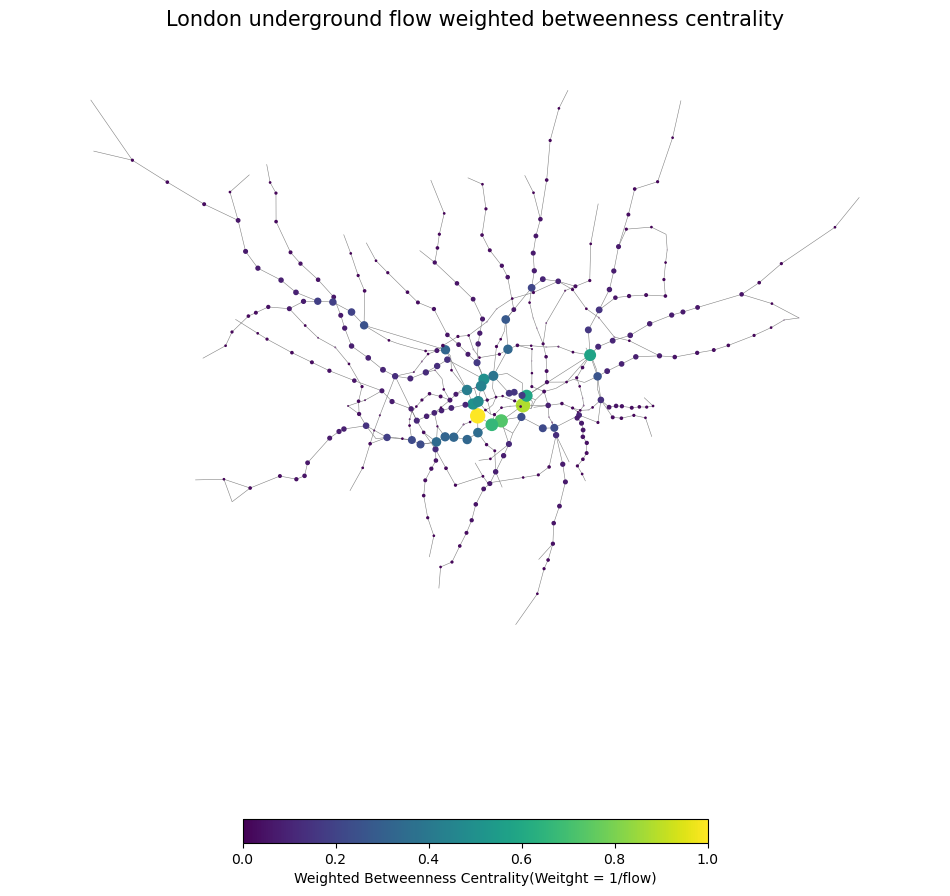

In [44]:
# Lets set colour and size of nodes according to betweenness values
betweenness_w_values=[(i[1]['betweenness_w']) for i in G_weighted.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in G_weighted.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 for i in G_weighted.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G_weighted, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G_weighted, pos = pos, node_color= bet_w_color, node_size= bet_w_size)

plt.colorbar(nod,label="Weighted Betweenness Centrality(Weitght = 1/flow)",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London underground flow weighted betweenness centrality",fontsize=15)
plt.show()

#### Compare

In [45]:
print("Topological Betweenness Centrality:")
print(df_bet_t.head(10))  # 展示前10条数据
print("\n Flow Weighted Betweenness Centrality:")
print(df_bet_w.head(10))  # 展示前10条数据

Topological Betweenness Centrality:
                                      station_name  betweenness_t
Stratford                                Stratford   23768.093434
Bank and Monument                Bank and Monument   23181.058947
Liverpool Street                  Liverpool Street   21610.387049
King's Cross St. Pancras  King's Cross St. Pancras   20373.521465
Waterloo                                  Waterloo   19464.882323
Green Park                              Green Park   17223.622114
Euston                                      Euston   16624.275469
Westminster                            Westminster   16226.155916
Baker Street                          Baker Street   15287.107612
Finchley Road                        Finchley Road   13173.758009

 Flow Weighted Betweenness Centrality:
                        station_name  betweenness_w
Green Park                Green Park       0.572556
Bank and Monument  Bank and Monument       0.505288
Waterloo                    Waterloo      

### II.2 Impact Measure for Stations Removal

#### Weighted Global Efficiency （Weight = 1/flow）

In [46]:
def flow_weighted_global_efficiency(G_weighted, weight='inv_flow'):
    """Calculate the weighted global efficiency of the graph using inverse flow as weight."""
    N = len(G_weighted)
    if N < 2:  # 图中如果少于两个节点，效率为0
        return 0

    eff = 0.0
    # 遍历图中的每个节点
    for u in G_weighted.nodes():
        # 计算从节点u到所有其他节点的加权最短路径长度
        path_length = nx.single_source_dijkstra_path_length(G_weighted, u, weight=weight)
        # 计算效率并只包括实际可达的节点（路径长度大于0的）
        eff += sum(1.0 / d for d in path_length.values() if d > 0)

    # 确保除数不为零
    if N * (N - 1) == 0:
        return 0

    return eff / (N * (N - 1))  # 归一化全球效率

In [47]:
#The flow weight global efficiency of the current Weitght G
print("Flow Weight Global Efficiency:", flow_weighted_global_efficiency(G_weighted))

Flow Weight Global Efficiency: 0.10125619359712325


#### Flow Weighted Average (Shortest) Path Length

In [48]:
def average_weighted_shortest_path_length(G_weighted, weight='inv_flow'):
    """Calculate the average weighted shortest path length of a graph."""
    if nx.is_empty(G_weighted):  # 检查图是否为空
        return 0  # 对于空图，平均路径长度定义为0

    # 检查图是否连通，不连通则计算最大连通分量中的平均最短路径长度
    if nx.is_connected(G_weighted):
        return nx.average_shortest_path_length(G_weighted, weight=weight)
    else:
        # 只计算最大连通组件的平均路径长度
        largest_cc = max(nx.connected_components(G_weighted), key=len)
        subgraph = G_weighted.subgraph(largest_cc)
        return nx.average_shortest_path_length(subgraph, weight=weight)

In [49]:
#The Length Weigtht Average Shortest Path Length of the current G_weighted
print("Flow Weight Average Shortest Path Length:", average_weighted_shortest_path_length(G_weighted))

Flow Weight Average Shortest Path Length: 13.545997506234414


### II.3 Stations Removal

#### Creat Copies of G_weighted

In [50]:
Gw_1 = G_weighted.copy() #No-sequential Remove 3 highest in I.1
Gw_2= G_weighted.copy() #No-sequential Remove 3 highest in 2.1-Using Flow as Weight

In [51]:
print("Number of nodes in Gw_1 after copy:", Gw_1.number_of_nodes())
print("Number of edges in Gw_1 after copy:", Gw_1.number_of_edges())

print("Number of nodes in Gw_2 after copy:", Gw_2.number_of_nodes())
print("Number of edges in Gw_2 after copy:", Gw_2.number_of_edges())

Number of nodes in Gw_1 after copy: 401
Number of edges in Gw_1 after copy: 467
Number of nodes in Gw_2 after copy: 401
Number of edges in Gw_2 after copy: 467


#### Remove 3 highest in I.1

In [52]:
# 初始化列表来存储结果
removed_nodes = []
flow_efficiencies = []
avg_path_lengths = []

# 限制删除节点的数量为3，并逐个删除
for node in df_bet_t['station_name'][:3]:  # 获取排名最高的三个节点名称
    if node in Gw_1.nodes:  # 确保节点存在于图中
        Gw_1.remove_node(node)  # 删除节点
        
        # 计算指标
        flow_efficiency = flow_weighted_global_efficiency(Gw_1, weight='inv_flow')
        avg_path_length = average_weighted_shortest_path_length(Gw_1, weight='inv_flow')
        
        # 存储结果
        removed_nodes.append(node)
        flow_efficiencies.append(flow_efficiency)
        avg_path_lengths.append(avg_path_length)

# 创建一个包含所有信息的DataFrame
results_Gw_1 = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Flow Weighted Global Efficiency': flow_efficiencies,
    'Average Weighted Shortest Path Length': avg_path_lengths
})

results_Gw_1

,Removed Node,Flow Weighted Global Efficiency,Average Weighted Shortest Path Length
0,Stratford,0.088917,14.496447
1,Bank and Monument,0.085862,14.872497
2,Liverpool Street,0.084963,15.031209


#### Remove 3 highest in II.1-Flow Weight

In [53]:
# 初始化列表来存储结果
removed_nodes = []
flow_efficiencies = []
avg_path_lengths = []

# 限制删除节点的数量为3，并逐个删除
for node in df_bet_w['station_name'][:3]:  # 获取排名最高的三个节点名称
    if node in Gw_2.nodes:  # 确保节点存在于图中
        Gw_2.remove_node(node)  # 删除节点
        
        # 计算指标
        flow_efficiency = flow_weighted_global_efficiency(Gw_2, weight='inv_flow')
        avg_path_length = average_weighted_shortest_path_length(Gw_2, weight='inv_flow')
        
        # 存储结果
        removed_nodes.append(node)
        flow_efficiencies.append(flow_efficiency)
        avg_path_lengths.append(avg_path_length)

# 创建一个包含所有信息的DataFrame
results_Gw_2 = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Flow Weighted Global Efficiency': flow_efficiencies,
    'Average Weighted Shortest Path Length': avg_path_lengths
})

results_Gw_2

,Removed Node,Flow Weighted Global Efficiency,Average Weighted Shortest Path Length
0,Green Park,0.099190,13.824536
1,Bank and Monument,0.094872,14.382728
2,Waterloo,0.093323,14.672797


#### Plot and Analysis

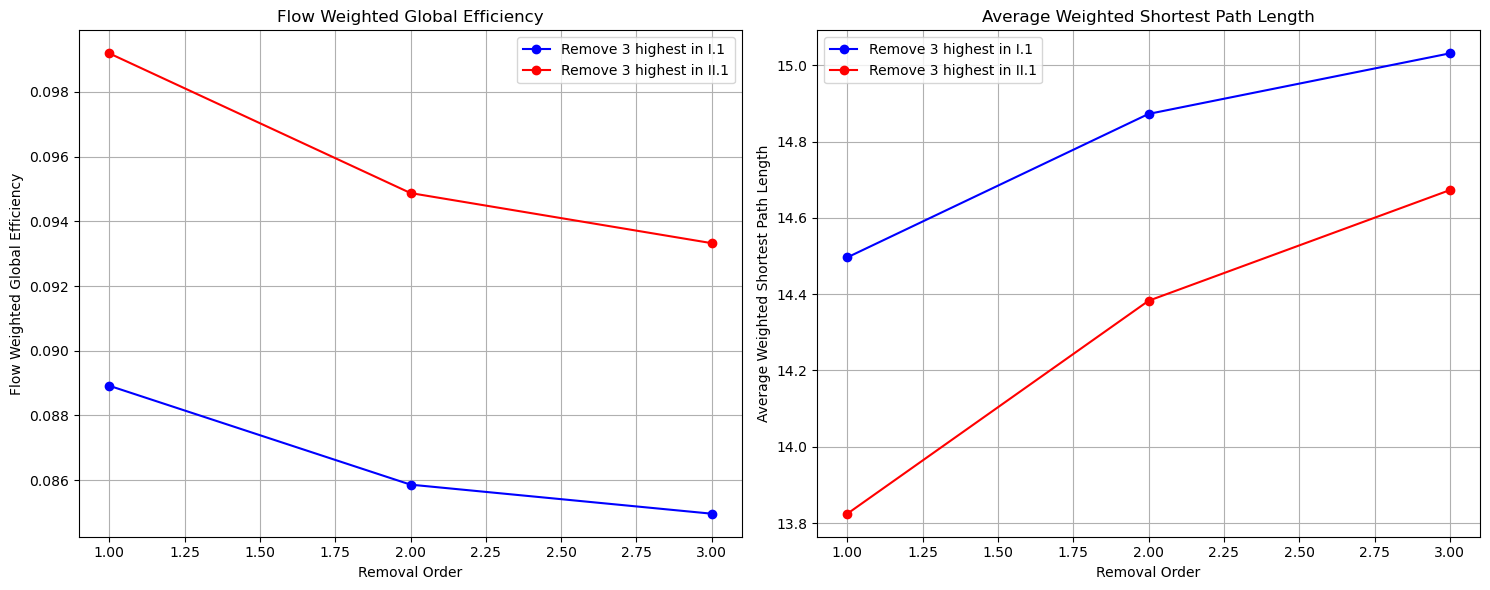

In [54]:
# 设置移除次序
results_Gw_1['Removal Order'] = range(1, len(results_Gw_1) + 1)
results_Gw_2['Removal Order'] = range(1, len(results_Gw_2) + 1)

# 绘制两张子图
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True)

# 子图1：Flow Weighted Global Efficiency
axes[0].plot(results_Gw_1['Removal Order'], results_Gw_1['Flow Weighted Global Efficiency'], marker='o', linestyle='-', color='blue', label='Remove 3 highest in I.1')
axes[0].plot(results_Gw_2['Removal Order'], results_Gw_2['Flow Weighted Global Efficiency'], marker='o', linestyle='-', color='red', label='Remove 3 highest in II.1')
axes[0].set_title('Flow Weighted Global Efficiency')
axes[0].set_xlabel('Removal Order')
axes[0].set_ylabel('Flow Weighted Global Efficiency')
axes[0].legend()
axes[0].grid(True)

# 子图2：Average Weighted Shortest Path Length
axes[1].plot(results_Gw_1['Removal Order'], results_Gw_1['Average Weighted Shortest Path Length'], marker='o', linestyle='-', color='blue', label='Remove 3 highest in I.1')
axes[1].plot(results_Gw_2['Removal Order'], results_Gw_2['Average Weighted Shortest Path Length'], marker='o', linestyle='-', color='red', label='Remove 3 highest in II.1')
axes[1].set_title('Average Weighted Shortest Path Length')
axes[1].set_xlabel('Removal Order')
axes[1].set_ylabel('Average Weighted Shortest Path Length')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Part 2: Spatial Interaction models

## III.Models and calibration

### III.1 Spatial interaction models

### III.2 Calibration of model

#### Prepare

In [55]:
# import data
london_flows = pd.read_csv("london_flows.csv")
london_flows.head(10)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
5,Abbey Road,Crossharbour,1,599,1208,6686.475560
6,Abbey Road,Custom House,0,599,845,3824.855630
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909
8,Abbey Road,Cyprus,7,599,850,6532.099618
9,Abbey Road,Devons Road,1,599,611,3958.324171


In [56]:
# check data
london_flows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [57]:
#remove Battersea Park
london_flows = london_flows[
    (london_flows['station_origin'] != 'Battersea Park') &
    (london_flows['station_destination'] != 'Battersea Park')
]

In [58]:
#check intra-borough flows
intra_flows = london_flows[(london_flows['station_origin'] == london_flows['station_destination'])]

intra_flows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 4985 to 56180
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       18 non-null     object 
 1   station_destination  18 non-null     object 
 2   flows                18 non-null     int64  
 3   population           18 non-null     int64  
 4   jobs                 18 non-null     int64  
 5   distance             18 non-null     float64
dtypes: float64(1), int64(3), object(2)
memory usage: 1008.0+ bytes


In [59]:
#now chop out the intra-borough flows
london_flows = london_flows[(london_flows['station_origin'] != london_flows['station_destination'])]

In [60]:
# check data again
london_flows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61413 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61413 non-null  object 
 1   station_destination  61413 non-null  object 
 2   flows                61413 non-null  int64  
 3   population           61413 non-null  int64  
 4   jobs                 61413 non-null  int64  
 5   distance             61413 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.3+ MB


In [61]:
population_data = london_flows[['station_origin', 'population']].copy()
population_data.rename(columns={'station_origin': 'station_destination'}, inplace=True)
population_data.drop_duplicates(subset='station_destination', inplace=True)

jobs_data = london_flows[['station_destination', 'jobs']].copy()
jobs_data.rename(columns={'station_destination': 'station_origin'}, inplace=True)
jobs_data.drop_duplicates(subset='station_origin', inplace=True)

In [62]:
# 合并population_data到london_flows，基于station_destination
london_flows = london_flows.merge(population_data, left_on='station_destination', right_on='station_destination', how='left')

# 合并jobs_data到london_flows，基于station_origin
london_flows = london_flows.merge(jobs_data, left_on='station_origin', right_on='station_origin', how='left')

In [63]:
#rename
london_flows.rename(columns={
    'population_x': 'O_pop',
    'population_y': 'D_pop',
    'jobs_x': 'D_jobs',
    'jobs_y': 'O_jobs'
}, inplace=True)

new_column_order = ['station_origin', 'O_pop', 'O_jobs', 'station_destination', 'D_pop', 'D_jobs', 'flows', 'distance']

# 重排DataFrame的列
london_flows = london_flows[new_column_order]
london_flows.head()

,station_origin,O_pop,O_jobs,station_destination,D_pop,D_jobs,flows,distance
0,Abbey Road,599,345,Bank and Monument,29494,78549,0,8131.525097
1,Abbey Road,599,345,Beckton,1179,442,1,8510.121774
2,Abbey Road,599,345,Blackwall,952,665,3,3775.448872
3,Abbey Road,599,345,Canary Wharf,14632,58772,1,5086.514220
4,Abbey Road,599,345,Canning Town,21125,15428,37,2228.923167


In [64]:
london_flows_submat = pd.pivot_table(london_flows, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

london_flows_submat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [65]:
# define functions
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

#### Explore

In [71]:
#创建两种 cost

#apply inverse power
london_flows['log_distance'] = np.log(london_flows['distance'])

# apply exponential decay 
london_flows["exp_distance"] = np.exp(london_flows["distance"])

In [74]:
#Calculate log of destination employment count with small addition to solve div by zero error
london_flows['log_dest_jobs'] = np.log(london_flows['D_jobs'] + 0.001)

In [75]:
london_flows.head()

,station_origin,O_pop,O_jobs,station_destination,D_pop,D_jobs,flows,distance,log_distance,exp_distance,log_dest_jobs
0,Abbey Road,599,345,Bank and Monument,29494,78549,0,8131.525097,9.003504,inf,11.271478
1,Abbey Road,599,345,Beckton,1179,442,1,8510.121774,9.049012,inf,6.091312
2,Abbey Road,599,345,Blackwall,952,665,3,3775.448872,8.236275,inf,6.499789
3,Abbey Road,599,345,Canary Wharf,14632,58772,1,5086.514220,8.534348,inf,10.981421
4,Abbey Road,599,345,Canning Town,21125,15428,37,2228.923167,7.709274,inf,9.643939


In [78]:
#Production-constrained Model-inverse

#create the formula (the "-1" indicates no intercept in the regression model).
formula1 = 'flows ~ station_origin + log_dest_jobs + log_distance-1'
#run a production constrained sim
Sim1 = smf.glm(formula = formula1, data=london_flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(Sim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Fri, 19 Apr 2024   Deviance:                   1.8615e+06
Time:                        19:53:50   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [80]:
london_flows["fit1"] = np.round(Sim1.mu,0)

#Summary Statistics
print("RSquared =")
print(CalcRSquared(london_flows["flows"], london_flows["fit1"]))
print("RMSE =")
print(CalcRMSE(london_flows["flows"], london_flows["fit1"]))

RSquared =
0.3882763950178635
RMSE =
102.893


In [81]:
#Production-constrained Model-exponential

#create the formula (the "-1" indicates no intercept in the regression model).
formula2 = 'flows ~ station_origin + log_dest_jobs + distance-1'
#run a production constrained sim
Sim2 = smf.glm(formula = formula2, data=london_flows, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(Sim2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Fri, 19 Apr 2024   Deviance:                   1.6477e+06
Time:                        20:02:28   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [82]:
london_flows["fit2"] = np.round(Sim2.mu,0)

#Summary Statistics
print("RSquared =")
print(CalcRSquared(london_flows["flows"], london_flows["fit2"]))
print("RMSE =")
print(CalcRMSE(london_flows["flows"], london_flows["fit2"]))

RSquared =
0.46806533672572287
RMSE =
96.263


## IV.Scenarios